In [1]:
from pathlib import Path

import pandas as pd
from dacboenv.experiment.analysis.utils import RWBM, postprocess_benchmarks, create_yaml_string
from carps.analysis.gather_data import filelogs_to_df, get_interpolated_performance_df, normalize_logs
from carps.analysis.generate_report import load_results
from carps.analysis.utils import filter_only_final_performance
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
import ast
from omegaconf import OmegaConf

df_final_processed_fn = "eval_final_perf.parquet"
logsprocessed_fn = "logs_processed.parquet"
logsprocessed_cfg_fn = "logs_processed_cfg.parquet"
key_performance = "log_regret"
result_dir = "../results_icml"

def rename_policies(logs: pd.DataFrame, id_col: str = "optimizer_id", reduce_seeds: bool = False) -> pd.DataFrame:
    smac_symbol = "SMAC"  #"🚂"    # "0️⃣"
    sawei_symbol = "SAWEI"  #"🚅"  #"1️⃣"
    dim_str = ""
    renaming = {
        "reward_id": {
            "symlogregret-SAWEI-P": f"symlogregret-{sawei_symbol}",
            "symlogregret-SMAC3-BlackBoxFacade": f"symlogregret-{smac_symbol}",
            "episode_finished_scaled-SAWEI-P": f"eplen-{sawei_symbol}",
            "episode_finished_scaled-SMAC3-BlackBoxFacade": f"eplen-{smac_symbol}",
        },
        "instance_set_id": {
            "bbob2d_fid8_3seeds": f"fid8{dim_str}",
            "bbob2d_3seeds": f"bbob{dim_str}"
        }
    }
    suffix = "_plot"
    ids = logs[id_col].str.contains("PPO")
    if "reward_id" not in logs.loc[ids]:
        # PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-SMAC3-BlackBoxFacade_Ibbob2d_3seeds--seed1
        logs.loc[ids, "reward_id"] = logs.loc[ids, "optimizer_id"].map(lambda x: x.split("_R")[1].split("_I")[0])
        logs.loc[ids, "instance_set_id"] = logs.loc[ids, "optimizer_id"].map(lambda x: x.split("_I")[1].split("--")[0])
        logs.loc[ids, "inner_seeds"] = logs.loc[ids, "optimizer_id"].map(lambda x: x.split("--")[-1])
    for key, value in renaming.items():
        logs.loc[ids, key + suffix] = logs.loc[ids, key].map(lambda x: value[x])
    logs.loc[ids, "policy_id"] = "PPO-" + logs.loc[ids, "reward_id" + suffix] + "-" + logs.loc[ids, "instance_set_id" + suffix] + "-" + logs.loc[ids, "inner_seeds"]
    logs.loc[ids, id_col] = logs.loc[ids, "policy_id"]
    if not reduce_seeds:
        detailed_results = logs.loc[ids].copy()
        # seed_suffix = logs.loc[ids, "optimizer_id"].map(lambda x: x.split("--")[-1].replace("seed",""))
        # logs.loc[ids, "policy_id"] = logs.loc[ids, "policy_id"] + "-" + seed_suffix
        logs.loc[ids, "policy_id"] = logs.loc[ids, "policy_id"].map(lambda x: "-".join(x.split("-")[:-1]))
        logs.loc[ids, id_col] = logs.loc[ids, "policy_id"]
        print(detailed_results["optimizer_id"].unique())
        logs = pd.concat([logs, detailed_results]).reset_index(drop=True)

    print(logs["policy_id"].unique())
    logs.loc[logs["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
    return logs

def fix_benchmark_id(logs: pd.DataFrame) -> pd.DataFrame:
    def _fix_benchmark_id(row: pd.Series) -> str:
        if row["task_id"].startswith("bbob/2"):
            return "BBOB-2d"
        if row["task_id"].startswith("bbob/8"):
            return "BBOB-8d"
        return row["benchmark_id"]
    logs["benchmark_id"] = logs.apply(_fix_benchmark_id, axis="columns")
    return logs

def add_metadata(logs: pd.DataFrame, logs_cfg: pd.DataFrame) -> pd.DataFrame:
    def _get_metadata(cfg_str: str) -> dict:
        yaml_str = create_yaml_string(cfg_str)
        cfg = OmegaConf.create(yaml_str)
        D = add_metadata_to_dict({}, cfg)
        del D["config"]
        return D

    logs_cfg["metadata"] = logs_cfg["cfg_str"].map(_get_metadata)

    logs = logs.merge(
        logs_cfg[["experiment_id", "metadata"]],
        on="experiment_id",
        how="left"
    )
    logs = pd.concat(
        [logs.drop(columns="metadata"), logs["metadata"].apply(pd.Series)],
        axis=1
    )

    return logs


def postprocess_logs(logs: pd.DataFrame, logs_cfg: pd.DataFrame) -> pd.DataFrame:
    # print("Add metadata...")
    # logs = add_metadata(logs, logs_cfg)
    # print("Rename policies...")
    # logs = rename_policies(logs)
    print("Postprocess benchmarks...")
    logs = postprocess_benchmarks(logs, logs_cfg)
    print("Fix benchmark id...")
    logs = fix_benchmark_id(logs)
    print("Done postprocessing logs!")
    return logs


def load_logs(result_dir: str) -> tuple[pd.DataFrame,pd.DataFrame]:
    logs = load_results(Path(result_dir) / "logs.parquet", normalize=True)
    logs_cfg = pd.read_parquet(Path(result_dir) / "logs_cfg.parquet")
    logs = postprocess_logs(logs, logs_cfg)
    return logs, logs_cfg

# Load and merge
skip_processing = True
if not (Path(result_dir) / logsprocessed_fn).is_file():
    skip_processing = False
    print(f"{Path(result_dir) / logsprocessed_fn} does not exist. Load and process.")

if not skip_processing:
    logs, logs_cfg = load_logs(result_dir=result_dir)
    logs.to_parquet(Path(result_dir) / logsprocessed_fn)
    logs_cfg.to_parquet(Path(result_dir) / logsprocessed_cfg_fn)
    df_final = filter_only_final_performance(logs)
    df_final.to_parquet(Path(result_dir) / df_final_processed_fn, index=False)
# else:
#     logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
#     logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
#     df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)


# Log Regret over Time Single Task

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn, get_color_palette, get_marker_palette
import pandas as pd

setup_seaborn()
%matplotlib inline

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

palette = get_color_palette(logs)
palette["NoOpPolicy"] = "black"
marker_palette = get_marker_palette(logs)
for task_id, group in logs.groupby("task_id"):
    if not group.iloc[0]["benchmark_id"].startswith("Opt"):
        continue
    if task_id.startswith("bbob/4"):
        continue
    # if task_id != "bbob/8/8/0":
    #     continue
    # if not task_id.startswith("bbob"):
    #     continue
    ax = sns.lineplot(
        data=group, x="n_trials", y=key_performance, hue="optimizer_id", palette=palette, style="optimizer_id", dashes=False, markers=marker_palette, markevery=10)
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_title(task_id)
    plt.show()
    break



# Log Regret over Time Single per Benchmark

['PPO-RNN-norm--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-DefaultAction_Ibbob2d_fid8_3seeds--seed5'
 'PPO-RNN-norm--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-DefaultAction_Ibbob2d_3seeds--seed2'
 'PPO-RNN-norm--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-DefaultAction_Ibbob2d_3seeds--seed3'
 'PPO-RNN-norm--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-skip_Ssawei_Repisode_finished_scaled-DefaultAction_Ibbob2d_fid8_3seeds--seed2'
 'PPO-RNN-norm--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-DefaultAction_Ibbob2d_3seeds--seed5'
 'PPO-RNN-norm--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-DefaultAction_Ibbob2d_fid8_3seeds--seed1'
 'PPO-RNN-norm--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-skip_Ssawei_Repisode_finished_scaled-DefaultAction_Ibbob2d_3seeds--seed1'
 'PPO-RNN-norm--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-DefaultAction_I

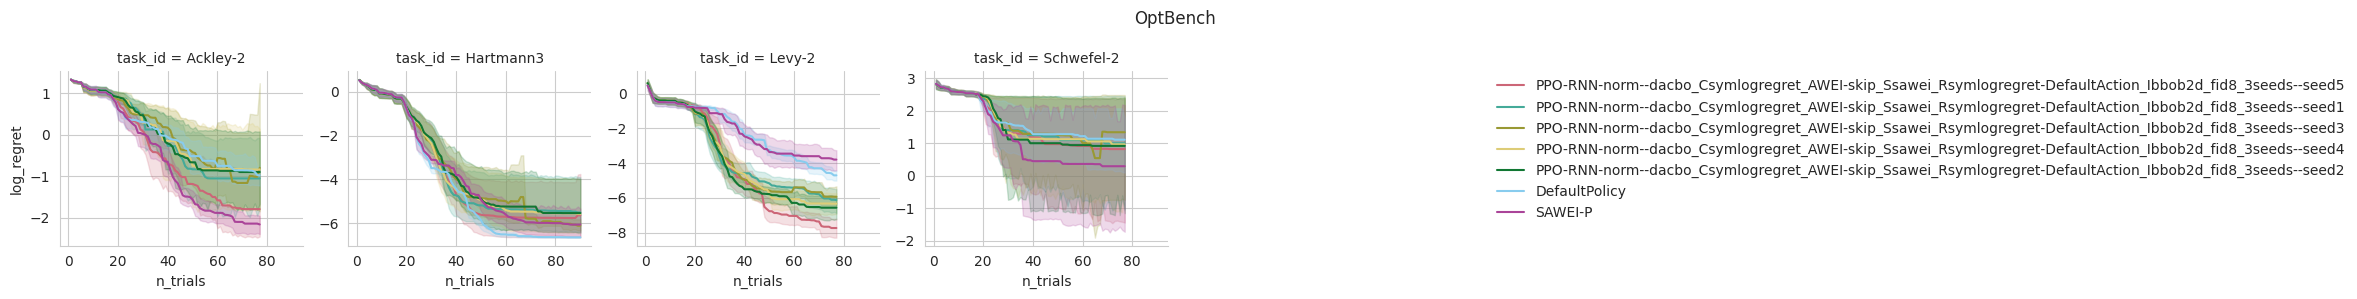

In [15]:

import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn, get_color_palette, get_marker_palette
import pandas as pd

setup_seaborn()
%matplotlib inline

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

print(logs["optimizer_id"].unique())

logs = logs[
    (logs["optimizer_id"].isin(["DefaultPolicy", "NoOpPolicy", "Random", "SAWEI-P"])) \
    | ((logs["optimizer_id"].str.contains("symlog")) \
    & (logs["optimizer_id"].str.contains("skip")) \
    & (logs["optimizer_id"].str.contains("fid8")) \
    & (logs["optimizer_id"].str.contains("DefaultAction")) \
    & (logs["optimizer_id"].str.contains("norm")) \
    )
]
palette = get_color_palette(logs)
marker_palette = get_marker_palette(logs)

for benchmark_id, group in logs.groupby("benchmark_id"):
    if not benchmark_id.startswith("Opt"):
        continue

    grid = sns.FacetGrid(data=group, col="task_id", col_wrap=5, height=3, sharex=True, sharey=False)

    grid.map_dataframe(
        sns.lineplot, x="n_trials", y=key_performance, hue="optimizer_id", palette=palette, )#style="optimizer_id", dashes=False, markers=marker_palette, markevery=10)
    grid.add_legend()
    grid.figure.suptitle(benchmark_id)
    grid.tight_layout()
    plt.show()



# Table

10


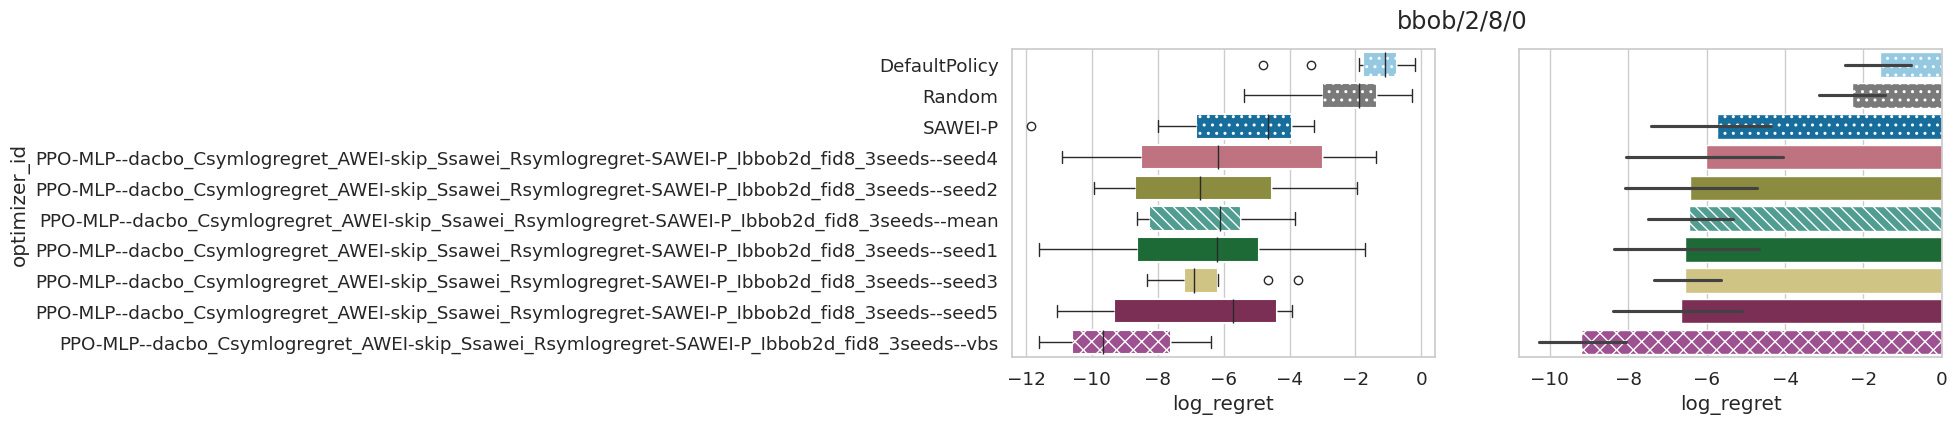

/tmp/ipykernel_2088180/2287848500.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


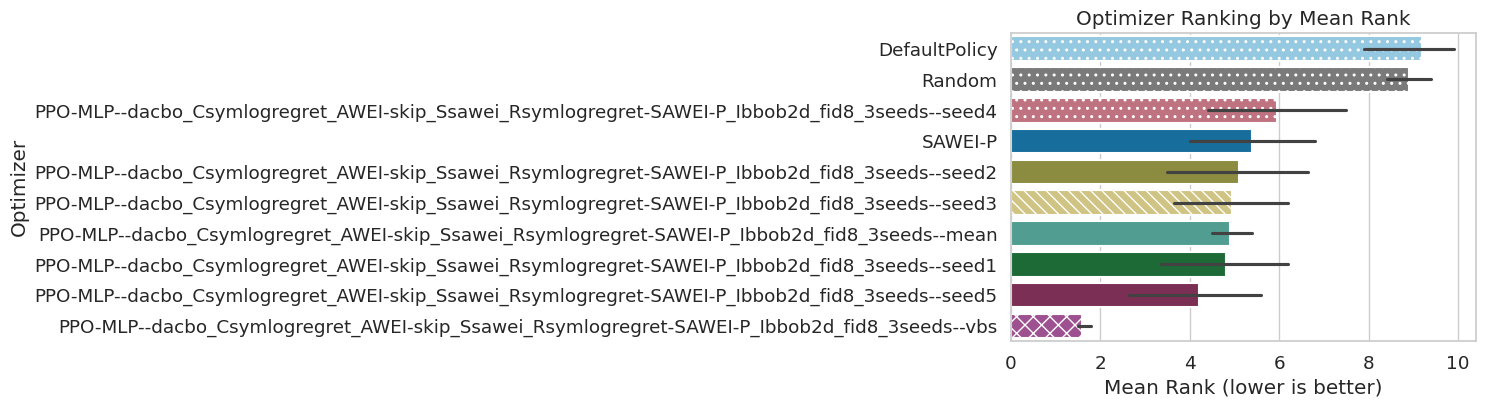

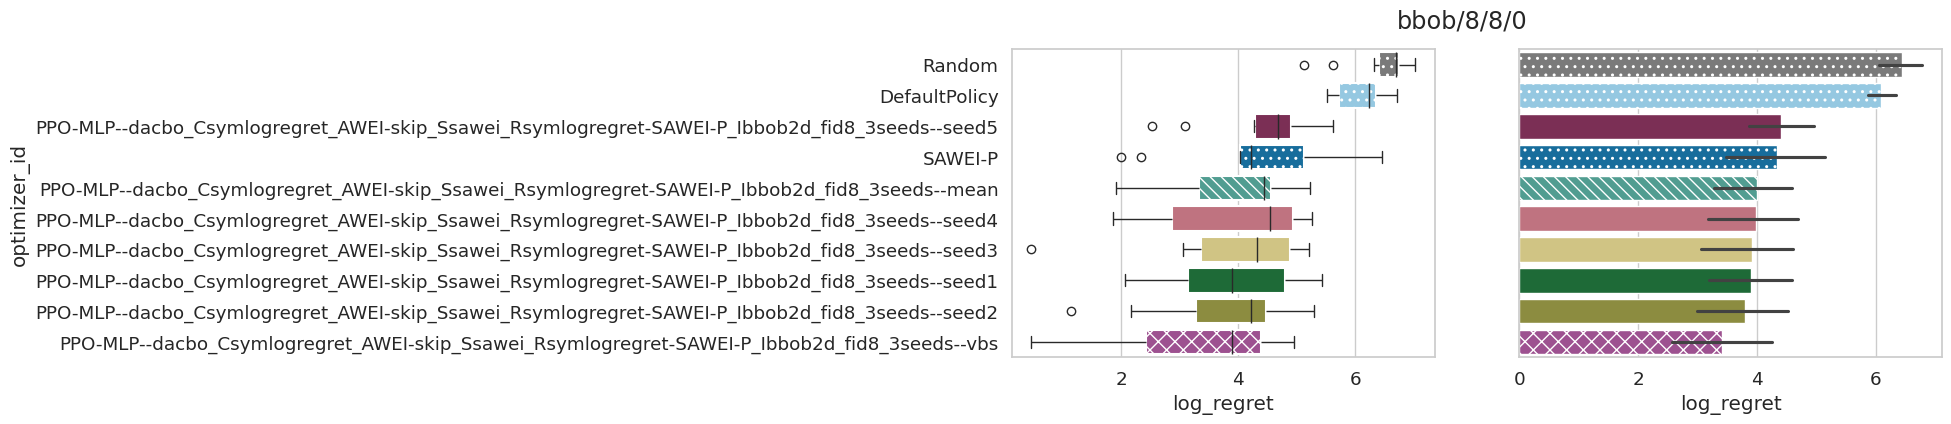

/tmp/ipykernel_2088180/2287848500.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


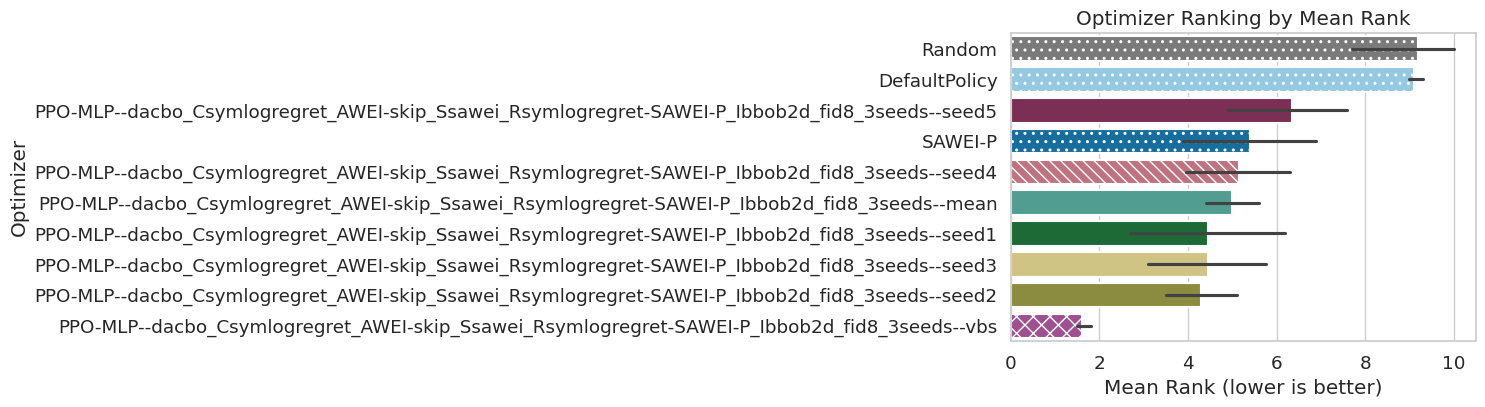

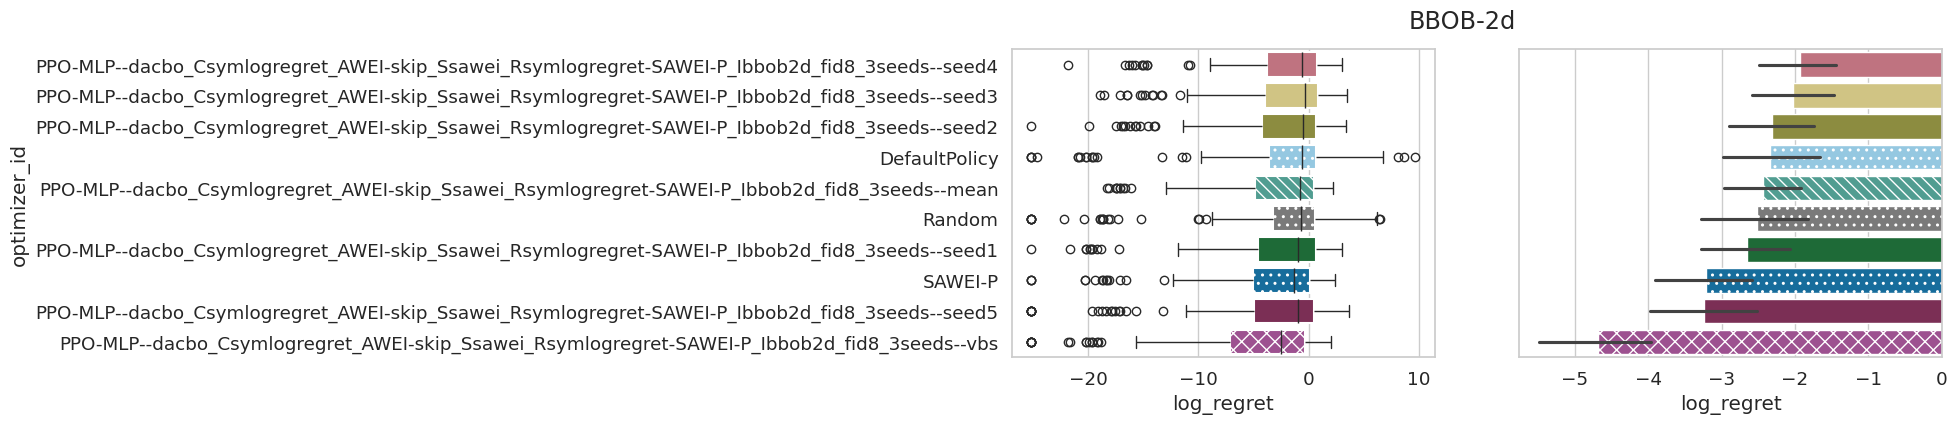

/tmp/ipykernel_2088180/2287848500.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


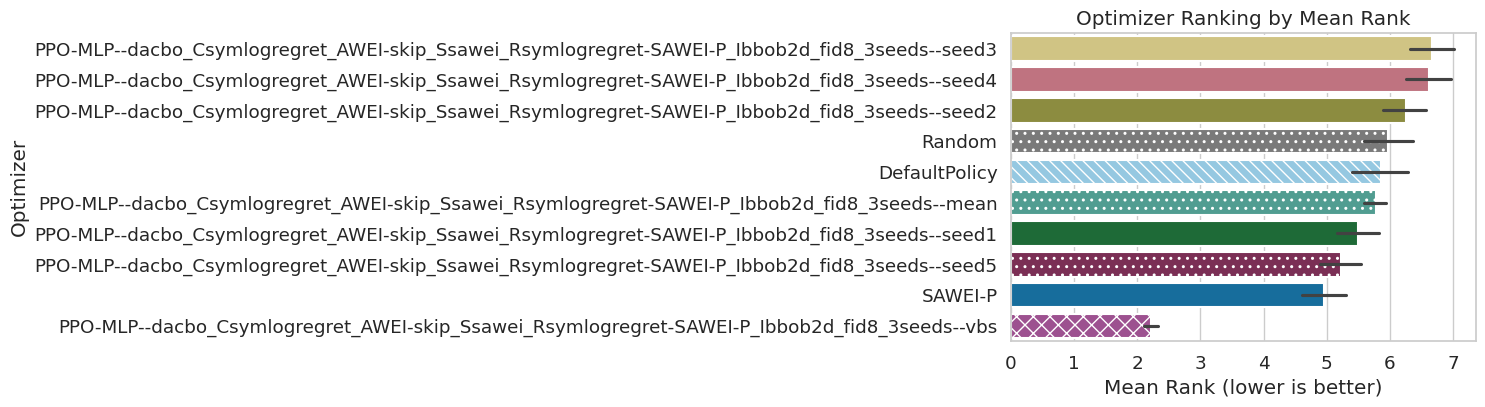

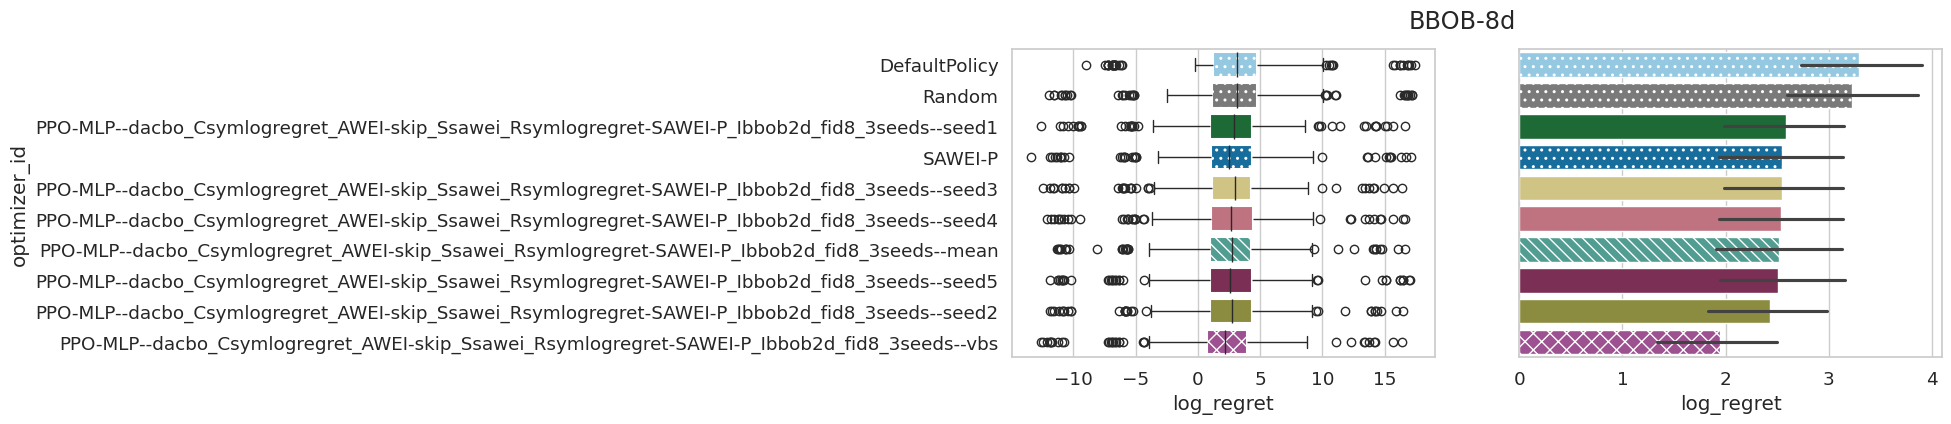

/tmp/ipykernel_2088180/2287848500.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


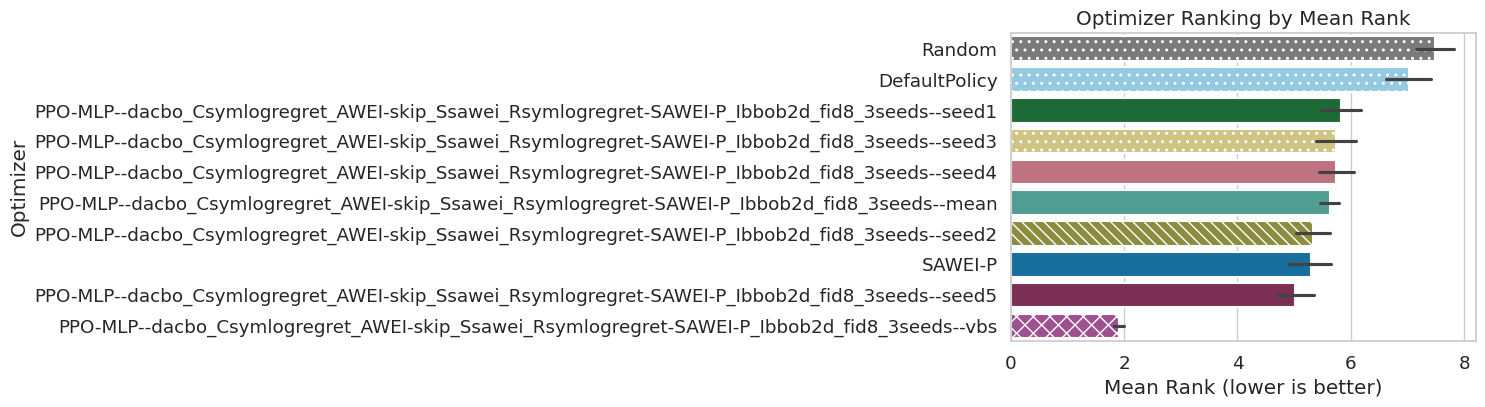

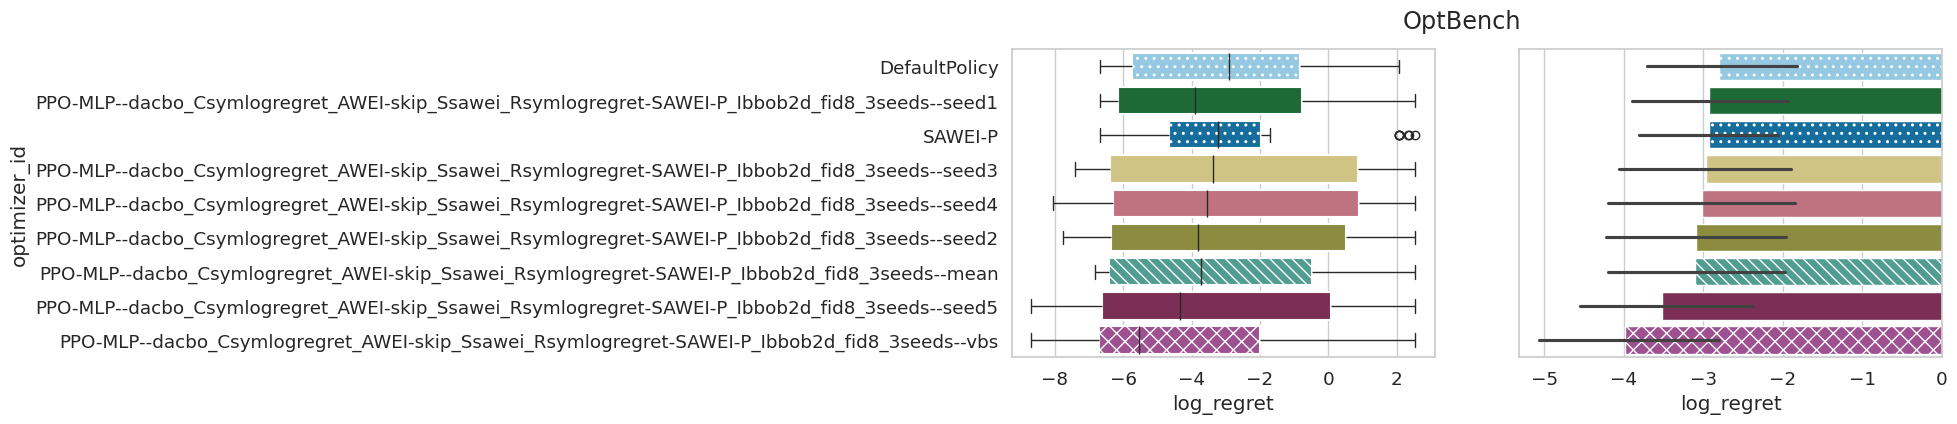

/tmp/ipykernel_2088180/2287848500.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


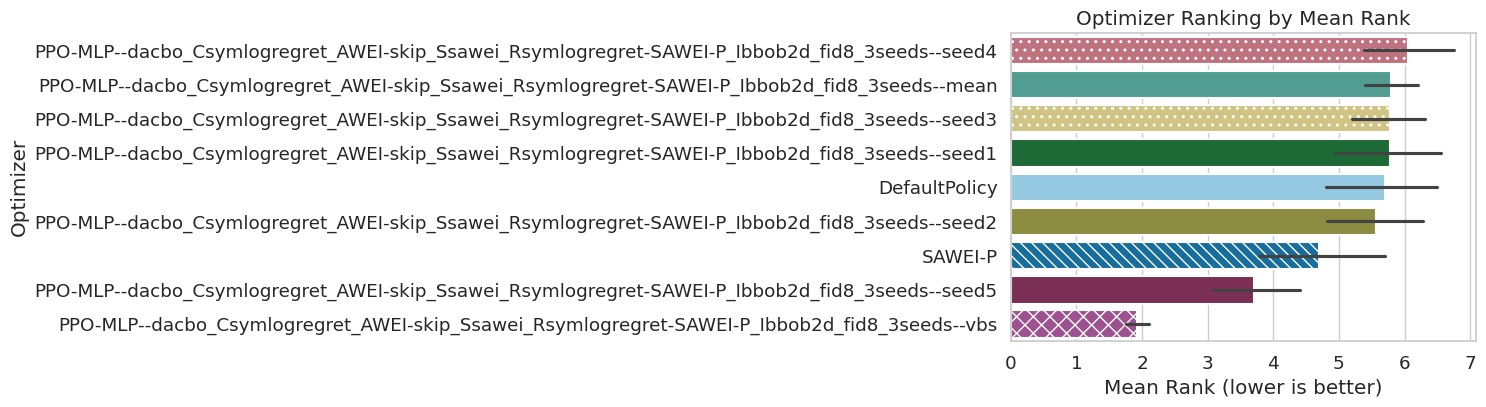

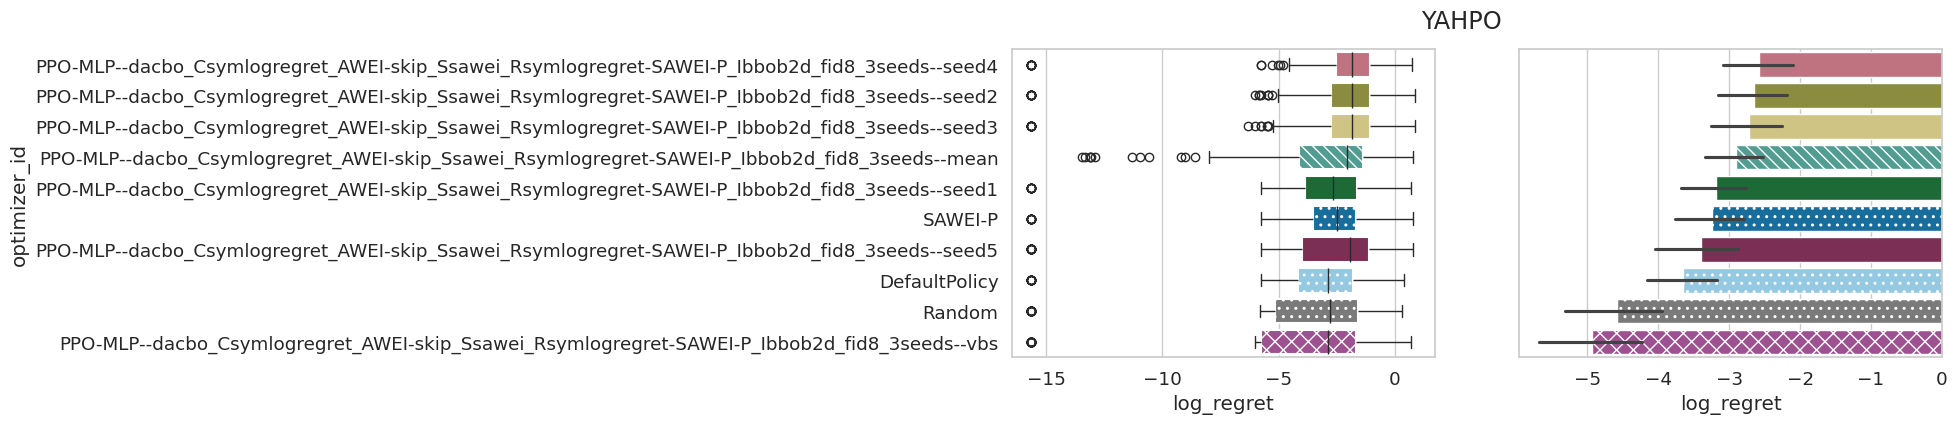

/tmp/ipykernel_2088180/2287848500.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


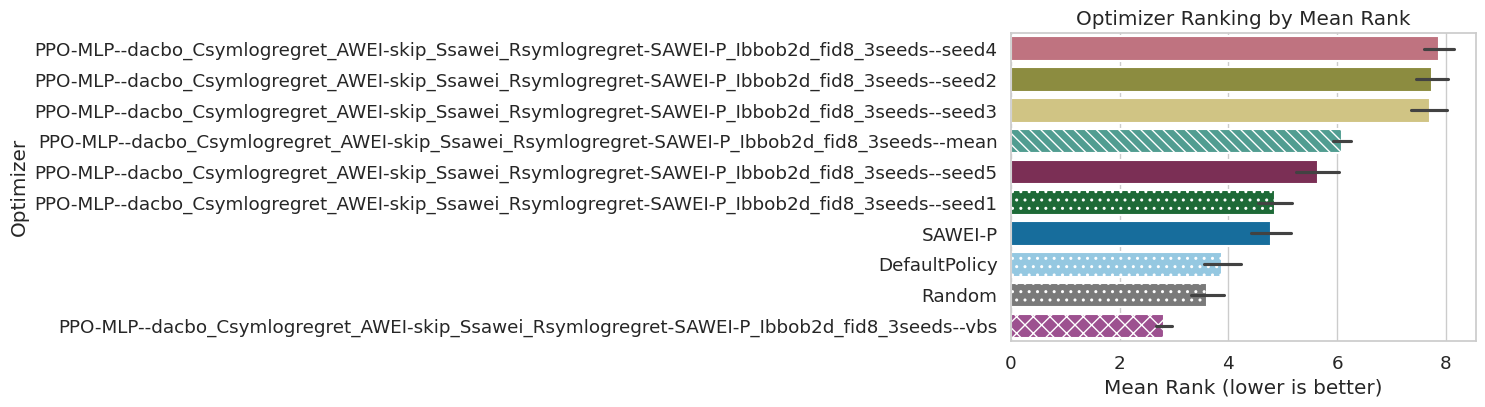

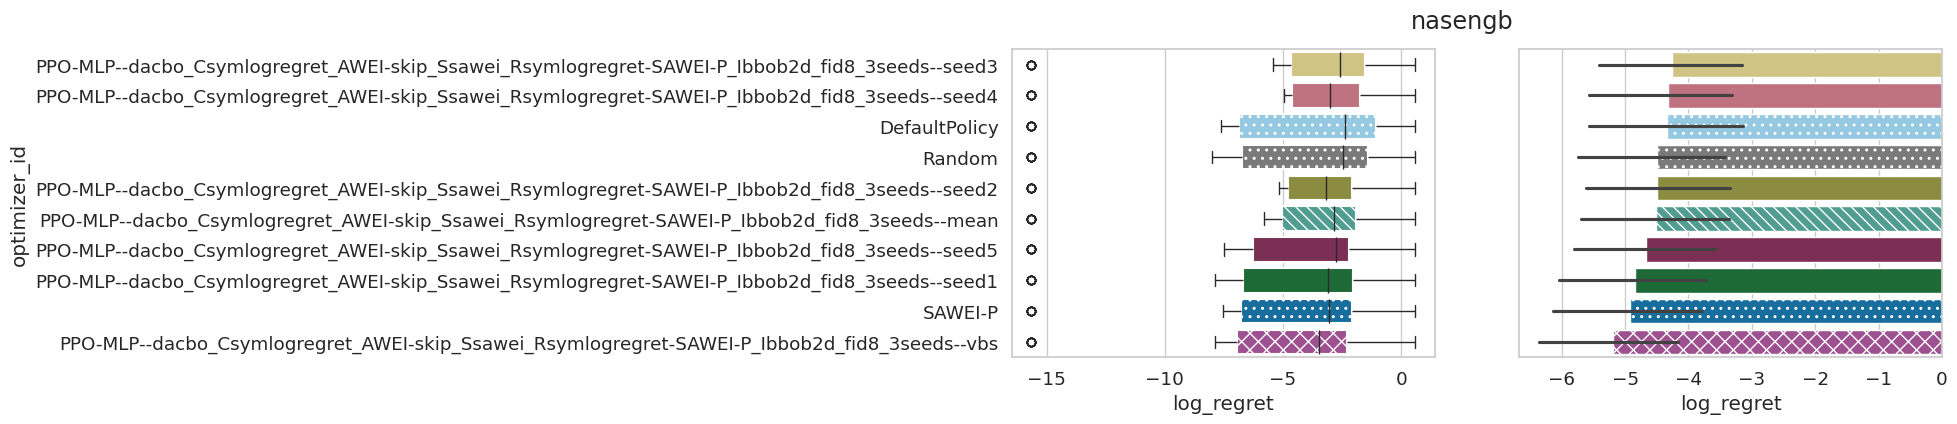

/tmp/ipykernel_2088180/2287848500.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


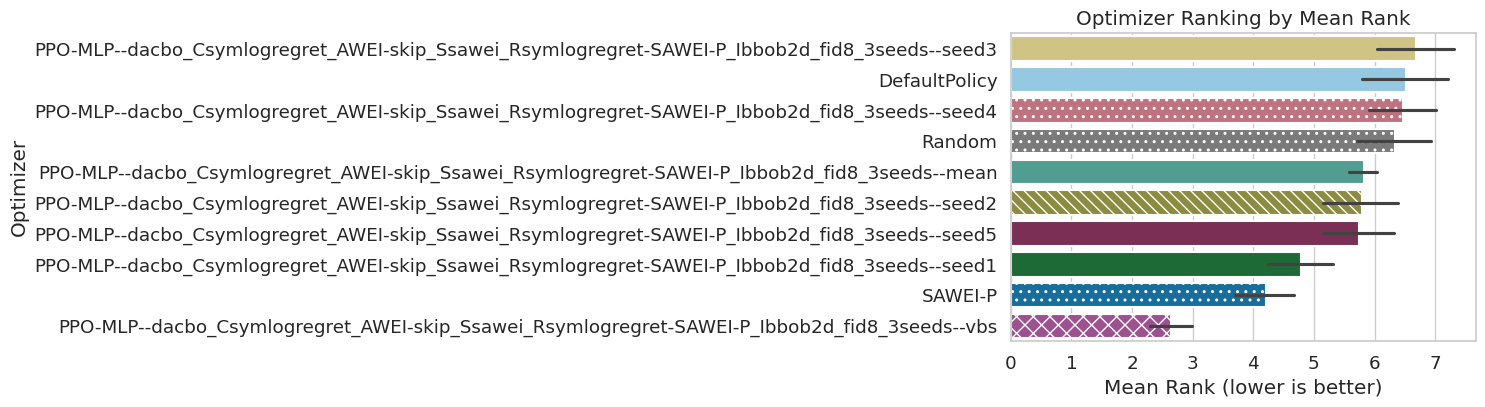

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
    colorblind_palette
)
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from carps.analysis.run_autorank import (
    calc_critical_difference,
    cd_evaluation,
    get_df_crit,
)

%matplotlib inline

setup_seaborn(font_scale=1.2)

def fix_log_regret_inf(df: pd.DataFrame) -> pd.DataFrame:
    finite_vals = df_final.loc[
        np.isfinite(df_final["log_regret"]),
        "log_regret"
    ]
    floor = finite_vals.min() - 0.5
    df["solved"] = df["log_regret"].eq(-np.inf)
    df["log_regret"] = df["log_regret"].replace(-np.inf, floor)
    return df


def filter_experiments(df: pd.DataFrame) -> pd.DataFrame:
    optimizer_prefixes = [
        # "PPO-RNN-norm--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-DefaultAction_Ibbob2d_3seeds",
        "PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds",
        # "PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_3seeds",
        # "PPO",
        "DefaultPolicy",
        "Random",
        "SAWEI-P"
    ]
    df.loc[df["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
    return df[df["optimizer_id"].map(lambda x: any(x.startswith(opt_id) for opt_id in optimizer_prefixes))]

df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)
df_final = filter_experiments(df_final)
df_final = fix_log_regret_inf(df_final)

# Reduce PPO name
df_final_ppo = df_final[df_final["optimizer_id"].str.startswith("PPO")].copy()
df_final_ppo["outer_seed"] = df_final_ppo["optimizer_id"].map(lambda x: int(x.split("--")[-1].replace("seed", "")))
df_final_ppo["optimizer_id"] = df_final_ppo["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]))

# Average over outer seeds
df_final_ppo_mean = df_final_ppo.groupby(["benchmark_id", "optimizer_id", "task_id", "seed"])["log_regret"].mean().reset_index().copy()
df_final_ppo_mean["optimizer_id"] = df_final_ppo_mean["optimizer_id"] + "--mean"

# Calculate VBS over outer seeds
df_final_ppo_vbs = df_final_ppo.groupby(["benchmark_id", "optimizer_id", "task_id", "seed"])["log_regret"].min().reset_index().copy()
df_final_ppo_vbs["optimizer_id"] = df_final_ppo_vbs["optimizer_id"] + "--vbs"

df_final = pd.concat([df_final, df_final_ppo_mean, df_final_ppo_vbs]).reset_index(drop=True)



skip_plot = df_final["optimizer_id"].nunique() > 20
print(df_final["optimizer_id"].nunique())


# df_final["optimizer_id"] = df_final["optimizer_id"].map(lambda x: "PPO-fid8_2d--" + x.split("--")[-1] if "fid8" in x else x)
# df_final["optimizer_id"] = df_final["optimizer_id"].map(lambda x: "PPO-bbob_2d--" + x.split("--")[-1] if "bbob2d_3s" in x else x)
palette = get_color_palette(df_final)

# for k in palette:
#     if k.startswith("PPO-bbob_2d--"):
#         palette[k] = colorblind_palette[5]
#     elif k.startswith("PPO-fid8_2d--"):
#         palette[k] = colorblind_palette[3]

def plot(df, palette, title):
    fig = plt.figure(figsize=(12, 4))
    axes = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=True)

    # --- define hatch rules ---
    def hatch_for_optimizer(opt):
        if opt.endswith("vbs"):
            return "xx"
        if opt.endswith("mean"):
            return "\\\\\\"
        if opt.endswith("--seed") or "--seed" in opt:
            return ""
        if opt in {"DefaultPolicy", "SAWEI-P", "Random"}:
            return ".."
        return ""

    # build optimizer -> hatch map
    optimizer_order = df["optimizer_id"].unique()
    hatch_map = {
        opt: hatch_for_optimizer(opt)
        for opt in df["optimizer_id"].unique()
    }

    # --- boxplot ---
    ax = axes[0]
    sns.boxplot(
        data=df,
        x="log_regret",
        y="optimizer_id",
        hue="optimizer_id",
        palette=palette,
        ax=ax,
        dodge=False
    )

    # apply hatches to boxplot artists
    box_patches = [
        p for p in ax.patches
        if isinstance(p, plt.matplotlib.patches.PathPatch)
    ]

    for patch, opt in zip(box_patches, optimizer_order):
        patch.set_hatch(hatch_map[opt])
        patch.set_edgecolor("white")   # ← hatch color
        patch.set_linewidth(1.5)       # helps visibility

    # --- barplot ---
    ax = axes[1]
    sns.barplot(
        data=df,
        x="log_regret",
        y="optimizer_id",
        hue="optimizer_id",
        palette=palette,
        ax=ax,
        dodge=False
    )

    # apply hatches to barplot patches
    for patch, opt in zip(ax.patches, df["optimizer_id"].unique()):
        patch.set_hatch(hatch_map.get(opt, ""))

    fig.suptitle(title)
    savefig(fig, f"figures/results_icml/final_{title.replace('/','_')}")
    plt.show()

    # ######################## Ranks
    rank_df = df.assign(
        rank=df.groupby(["task_id", "seed"])["log_regret"]
            .rank(method="average", ascending=True)
    )
    rank_df = sort_df_by_mean(rank_df, key_performance="rank")

    # --- plot ---
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(
        data=rank_df,
        x="rank",
        y="optimizer_id",
        hue="optimizer_id",
        palette=palette
    )

    # apply hatches
    for patch, opt in zip(ax.patches, df["optimizer_id"].unique()):
        patch.set_hatch(hatch_map.get(opt, ""))
        patch.set_edgecolor("white")
        patch.set_linewidth(1.5)

    ax.set_xlabel("Mean Rank (lower is better)")
    ax.set_ylabel("Optimizer")
    ax.set_title("Optimizer Ranking by Mean Rank")

    plt.tight_layout()
    plt.show()

    # df_crit = get_df_crit(gdf, perf_col="log_regret")
    # perf_col = "log_regret"
    # df_crit = df.groupby(["optimizer_id", "task_id"])[perf_col].apply(np.nanmean).reset_index().copy()
    # df_crit = df_crit.pivot_table(index="task_id", columns="optimizer_id", values=perf_col)
    # _ = cd_evaluation(
    #     df_crit,
    #     maximize_metric=False,
    #     ignore_non_significance=True,
    #     output_path=f"figures/results_icml/{title.replace('/','_')}",
    #     figsize=(12,4),
    #     plot_diagram=True,
    #     show_figure=True,
    # )


tasks = ["bbob/2/8/0", "bbob/8/8/0"]
for task_id in tasks:
    df_task = df_final[df_final["task_id"] == task_id]
    df_task = sort_df_by_mean(df_task, key_performance="log_regret")

    df_task_mean = df_task.groupby("optimizer_id")[key_performance].apply(np.nanmean).sort_values(ascending=False)
    df_task_mean.to_csv(f"finalmean_{task_id.replace('/','_')}.csv")

    if not skip_plot:
        plot(df_task, palette, task_id)

for benchmark_id, gdf in df_final.groupby("benchmark_id"):
    n_tasks = gdf["task_id"].nunique()

    valid_opts = (
        gdf.groupby("optimizer_id")["task_id"]
        .nunique()
        .loc[lambda s: s == n_tasks]
        .index
    )

    gdf = gdf[gdf["optimizer_id"].isin(valid_opts)]

    gdf = sort_df_by_mean(gdf, key_performance="log_regret")

    gdf_mean = gdf.groupby("optimizer_id")[key_performance].apply(np.nanmean).sort_values(ascending=False)
    gdf_mean.to_csv(f"finalmean_{benchmark_id.replace('/','_')}.csv")

    if not skip_plot:
        plot(gdf, palette, benchmark_id)




# 2d fid8: Final Log Regret Boxplot & Log Regret over Time

/tmp/ipykernel_925308/1871963563.py:110: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


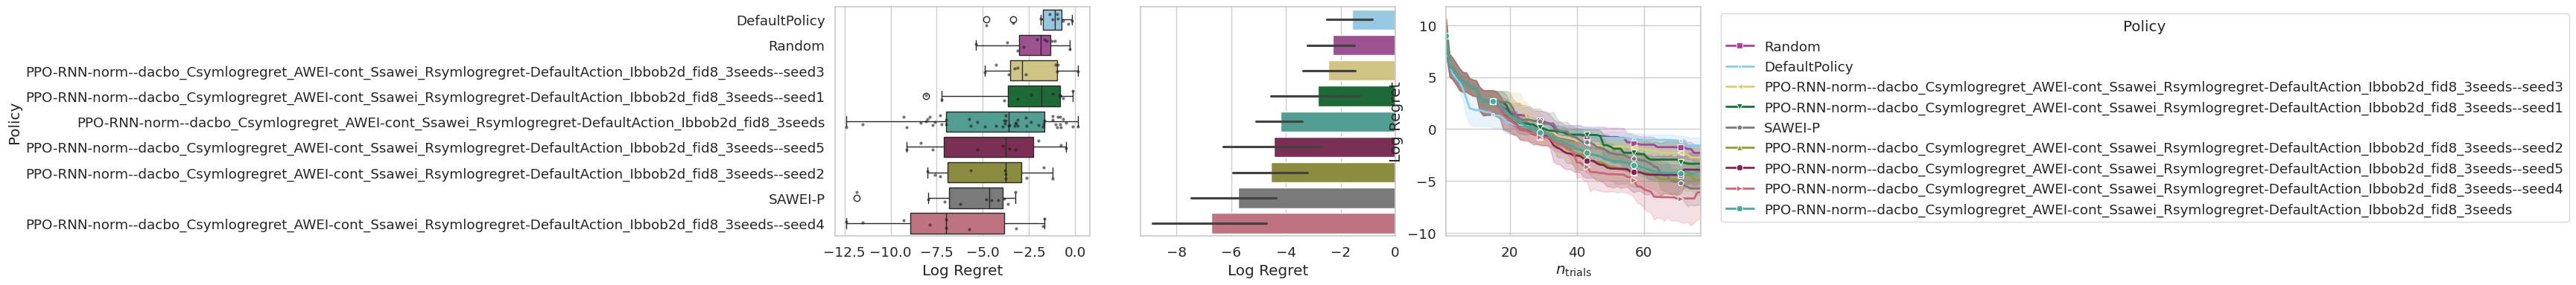

/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/pandas/core/groupby/ops.py:928: RuntimeWarning: Mean of empty slice
  res = f(group)


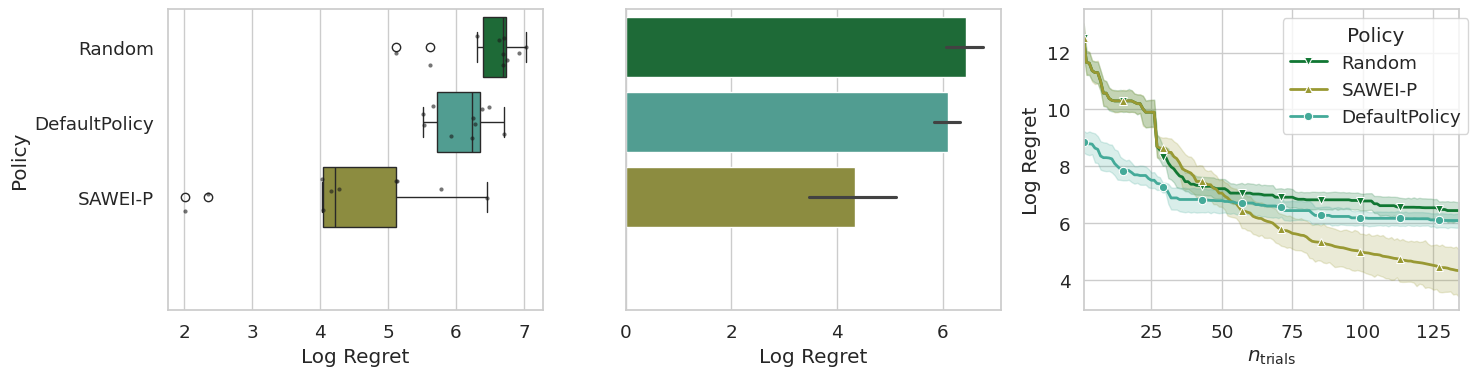

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs.loc[logs["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

# print(logs["optimizer_id"].unique())

# logs = logs[
#     # (logs["task_id"] == "bbob/2/8/0") \
#     (~logs["optimizer_id"].str.contains("bbob2d_3")) \
#     # & (~logs["optimizer_id"].str.contains("eplen")) \
#     & (~logs["optimizer_id"].str.contains("episode")) \
#     # & (~logs["optimizer_id"].str.contains("symlog")) \
#     & (~logs["optimizer_id"].str.contains("SMAC-")) \
#     & (~logs["optimizer_id"].str.contains("SMAC3-")) \
#     # & (~logs["optimizer_id"].str.contains("PPO-")) \
# ]
logs = logs[
    (logs["optimizer_id"].isin(["DefaultPolicy", "NoOpPolicy", "Random", "SAWEI-P"])) \
    | ((logs["optimizer_id"].str.contains("symlog")) \
    & (logs["optimizer_id"].str.contains("cont")) \
    & (logs["optimizer_id"].str.contains("fid8")) \
    & (logs["optimizer_id"].str.contains("DefaultAction")) \
    & (logs["optimizer_id"].str.contains("norm")) \
    )
]
# logs_ppo = logs[logs["optimizer_id"].str.startswith("PPO")].copy()
# logs_ppo["train_seed"] = logs_ppo["optimizer_id"].map(lambda x: int(x.split("--")[-1].replace("seed", "")))
# logs_ppo["optimizer_id"] = logs["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]))
# logs = pd.concat([logs, logs_ppo]).reset_index(drop=True)
# palette = get_color_palette(logs)
# markers = get_marker_palette(logs)

def reduce_ppo(logs: pd.DataFrame) -> pd.DataFrame:
    logs_ppo = logs[logs["optimizer_id"].str.startswith("PPO")].copy()
    logs_ppo["train_seed"] = logs_ppo["optimizer_id"].map(lambda x: int(x.split("--")[-1].replace("seed", "")))
    logs_ppo["optimizer_id"] = logs["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]))
    logs = pd.concat([logs, logs_ppo]).reset_index(drop=True)
    return logs

for task_id in ["bbob/2/8/0", "bbob/8/8/0"]:
    logs_to_plot = logs[logs["task_id"] == task_id]
    logs_to_plot = sort_df_by_mean(logs_to_plot, key_performance=key_performance)
    df_final = filter_only_final_performance(logs_to_plot)

    logs_to_plot = reduce_ppo(logs_to_plot)
    df_final = reduce_ppo(df_final)

    palette = get_color_palette(logs_to_plot)
    markers = get_marker_palette(logs_to_plot)


    df_final = sort_df_by_mean(df_final, key_performance=key_performance)
    hue_order = logs_to_plot["optimizer_id"].unique()

    fig = plt.figure(figsize=(15,4))
    axes = fig.subplots(ncols=3, sharex=False, sharey=False)
    ax = axes[2]
    ax = sns.lineplot(data=logs_to_plot, x="n_trials", y=key_performance, hue="optimizer_id", palette=palette,
                style="optimizer_id", dashes=False, markers=markers, markevery=14, linewidth=2,
                # estimator=None, units="seed", linewidth=0.5,
                ax=ax, hue_order=hue_order,
                )
    ax.legend(title="Policy", bbox_to_anchor=(1.05, 1))
    ax.set_xlim(logs_to_plot["n_trials"].min(), logs_to_plot["n_trials"].max())
    ax.set_xlabel("$n_\\mathrm{trials}$")
    ax.set_ylabel("Log Regret")

    ax = axes[0]
    ax = sns.boxplot(data=df_final, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=palette, ax=ax)
    ax.set_ylabel("Policy")
    ax.set_xlabel("Log Regret")

    sns.stripplot(
        data=df_final,
        y="optimizer_id",
        color="k",
        # hue="optimizer_id",
        # palette=palette,
        x="log_regret",
        order=hue_order,
        jitter=0.25,
        size=3,
        alpha=0.6,
        ax=ax
    )

    ax = axes[1]
    ax = sns.barplot(data=df_final, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=palette, ax=ax)
    ax.set_ylabel(None)
    ax.set_yticklabels([])
    ax.set_xlabel("Log Regret")

    fig.tight_layout()
    fn = "figures/results_icml/fid8_8d" if not "2" in task_id else "figures/results_icml/fid8_2d"
    savefig(fig=fig, filename=fn)
    plt.show()


# Fid8: 2d and 8d boxplot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D

%matplotlib inline

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

setup_seaborn(font_scale=1.2)

key_performance = "log_regret"
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].isin(["bbob/2/8/0","bbob/8/8/0"])) \
    & (~logs["optimizer_id"].str.contains("bbob2d_3")) \
    & (~logs["optimizer_id"].str.contains("-SMAC")) \
]
logs.loc[logs["task_id"] == "bbob/2/8/0", "task_id"] = "Rosenbrock-2d"
logs.loc[logs["task_id"] == "bbob/8/8/0", "task_id"] = "Rosenbrock-8d"
palette = get_color_palette(logs)
logs = sort_df_by_mean(logs, key_performance=key_performance)
logs = logs.sort_values(
    by="task_id",
    key=lambda x: x.str.extract('(\d+)')[0].astype(int)
)
df_final = filter_only_final_performance(logs)

key_performance = "Log Regret (Normalized)"
df_final[key_performance] = df_final.groupby("task_id")["log_regret"].transform(normalize)
df_final = df_final.sort_values(
    by="task_id",
    key=lambda x: x.str.extract('(\d+)')[0].astype(int)
)
df_final = sort_df_by_mean(df_final, key_performance=key_performance)
hue_order = logs["optimizer_id"].unique()
markers = get_marker_palette(logs)

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax = sns.boxplot(
    data=df_final, y=key_performance, hue="optimizer_id", x="task_id", palette=palette, ax=ax)
ax.legend(title="Policy", bbox_to_anchor=(1.05,1))
# ax.tick_params(axis="x", rotation=90)
ax.set_xlabel("Task ID")
fig.tight_layout()
savefig(fig=fig, filename="figures/results_icml/fid8_2d_vs_8d")
plt.show()


# Fid8 Generalization on BBOB 2d

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D
import numpy as np

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

key_performance = "log_regret"
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].str.startswith("bbob/2")) \
    & (~logs["optimizer_id"].str.contains("bbob2d_3")) \
    & (~logs["optimizer_id"].str.contains("episode")) \
    & (~logs["optimizer_id"].str.contains("-SMAC")) \
]
print(logs["task_id"].unique())
palette = get_color_palette(logs)
logs = sort_df_by_mean(logs, key_performance=key_performance)
df_final = filter_only_final_performance(logs)

# -----------------------------
# Sort optimizers by performance
# -----------------------------
optimizer_order = (
    df_final
    .groupby("optimizer_id")["regret"]
    .mean()
    .sort_values()
    .index
)

# -----------------------------
# Automatic floor for -inf
# -----------------------------
finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5

# -----------------------------
# Prepare plotting DataFrame
# -----------------------------
df_plot = df_final.copy()
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret_plot"] = df_plot["log_regret"].replace(-np.inf, floor)

df_plot["optimizer_id"] = pd.Categorical(
    df_plot["optimizer_id"],
    categories=optimizer_order,
    ordered=True
)

# -----------------------------
# Main plot: boxplot + jitter + annotations
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 4))


sns.stripplot(
    data=df_plot,
    y="optimizer_id",
    hue="optimizer_id",
    palette=palette,
    x="log_regret_plot",
    order=optimizer_order,
    jitter=0.25,
    size=3,
    alpha=0.6,
    ax=ax
)

sns.boxplot(
    data=df_plot,
    y="optimizer_id",
    x="log_regret_plot",
    hue="optimizer_id",
    palette=palette,
    order=optimizer_order,
    width=0.6,
    fliersize=0,
    ax=ax,
    fill=False,
    zorder=9999,
    linewidth=3,
    medianprops={"color": "black", "linewidth": 1.5},
)



# Annotate solved counts
solved_counts = df_plot.groupby("optimizer_id")["solved"].sum()

for y, opt in enumerate(optimizer_order):
    ax.text(
        floor + 0.02,
        y,
        f"{solved_counts[opt]} solved",
        va="center",
        ha="left",
        fontsize=8
    )

ax.axvline(floor, linestyle="--", linewidth=2, color="gray")
ax.set_xlabel("Final Log Regret")
ax.set_ylabel("Policy")
plt.tight_layout()
savefig(fig=fig, filename="figures/results_icml/fid8_2d_vs_bbob2d")
plt.show()

# key_performance_norm = "Log Regret (Normalized)"
# df_final[key_performance_norm] = df_final.groupby("task_id")["log_regret"].transform(normalize)

# df_final = sort_df_by_mean(df_final, key_performance=key_performance_norm)
# hue_order = logs["optimizer_id"].unique()
# markers = get_marker_palette(logs)

# fig = plt.figure(figsize=(10,3.5))
# ax = fig.add_subplot(111)
# ax = sns.boxplot(
#     data=df_final, x=key_performance_norm, hue="optimizer_id", y="optimizer_id", palette=palette, ax=ax)
# # ax.tick_params(axis="x", rotation=90)
# ax.set_xlabel("Log Regret (Normalized)")
# ax.set_ylabel("Policy")
# fig.tight_layout()
# savefig(fig=fig, filename="figures/results_icml/fid8_2d_vs_8d")
# plt.show()


# BBOB2d on BBOB2d

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import adaptaf.utils as au
importlib.reload(au)
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

key_performance = "log_regret"

palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].str.startswith("bbob/2")) \
    & (~logs["optimizer_id"].str.contains("fid8")) \
    & (~logs["optimizer_id"].str.contains("-SMAC")) \
    & (~logs["optimizer_id"].str.contains("episode")) \
]
palette = get_color_palette(logs)
df_final = filter_only_final_performance(logs)

# -----------------------------
# Sort optimizers by performance
# -----------------------------
optimizer_order = (
    df_final
    .groupby("optimizer_id")["regret"]
    .mean()
    .sort_values()
    .index
)

# -----------------------------
# Automatic floor for -inf
# -----------------------------
finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5

# -----------------------------
# Prepare plotting DataFrame
# -----------------------------
df_plot = df_final.copy()
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret_plot"] = df_plot["log_regret"].replace(-np.inf, floor)

df_plot["optimizer_id"] = pd.Categorical(
    df_plot["optimizer_id"],
    categories=optimizer_order,
    ordered=True
)

# -----------------------------
# Main plot: boxplot + jitter + annotations
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 4))


sns.stripplot(
    data=df_plot,
    y="optimizer_id",
    hue="optimizer_id",
    palette=palette,
    x="log_regret_plot",
    order=optimizer_order,
    jitter=0.25,
    size=3,
    alpha=0.6,
    ax=ax
)

sns.boxplot(
    data=df_plot,
    y="optimizer_id",
    x="log_regret_plot",
    hue="optimizer_id",
    palette=palette,
    order=optimizer_order,
    width=0.6,
    fliersize=0,
    ax=ax,
    fill=False,
    zorder=9999,
    linewidth=3,
    medianprops={"color": "black", "linewidth": 1.5},
)



# Annotate solved counts
solved_counts = df_plot.groupby("optimizer_id")["solved"].sum()

for y, opt in enumerate(optimizer_order):
    ax.text(
        floor + 0.02,
        y,
        f"{solved_counts[opt]} solved",
        va="center",
        ha="left",
        fontsize=8
    )

ax.axvline(floor, linestyle="--", linewidth=2, color="gray")
ax.set_xlabel("Final Log Regret")
ax.set_ylabel("Policy")
plt.tight_layout()
savefig(fig=fig, filename="figures/results_icml/bbob2d_on_bbob2d")
plt.show()




In [ ]:
# -----------------------------
# Heatmap with solved counts per cell
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data: number of runs solved per task & optimizer
# 1 if log_regret = -inf, 0 otherwise
df_solved = df_final.copy()
df_solved["solved"] = (df_solved["log_regret"] == -np.inf).astype(int)

# Pivot table: tasks x optimizers, sum over multiple runs
task_counts = df_solved.pivot_table(
    index="task_id",
    columns="optimizer_id",
    values="solved",
    aggfunc="sum",
    fill_value=0
).reindex(columns=optimizer_order)

# Binary mask for heatmap coloring: 1 = solved at least once
task_binary = (task_counts > 0).astype(int)

fig, ax = plt.subplots(figsize=(8, 8))

# Base heatmap: solved vs not solved
sns.heatmap(
    task_counts.T,
    cbar=False,
    linewidths=0.3,
    linecolor="gray",
    cmap="Greens",
    ax=ax,
    annot=task_counts.T,      # overlay the **number of solved runs**
    fmt="d",
    annot_kws={"fontsize": 8, "fontweight": "bold"}
)

ax.set_ylabel("Policy")
ax.set_xlabel("Task ID")
ax.set_title("Tasks on which the solution was found (numbers = solved runs)")

# plt.tight_layout()
savefig(fig=fig, filename="figures/results_icml/sol_found_bbob2d")
plt.show()


# Final Log Regret Agg Benchmark

In [ ]:
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import filter_only_final_performance, savefig
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)


logs = logs[logs["benchmark_id"] != "BBOB-2d"]
# logs = logs[
#         # (~logs["optimizer_id"].str.contains("fid8")) \
#         # & (~logs["optimizer_id"].str.contains("-SAWEI")) \
#         # & (~logs["optimizer_id"].str.contains("-SMAC")) \
#         # & (~logs["optimizer_id"].str.contains("sym")) 
# ]
logs.loc[logs["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
opts_to_plot = [
    "PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SMAC3-BlackBoxFacade_Ibbob2d_3seeds--seed3",
    "SAWEI-P",
    "DefaultPolicy",
    "Random"
]
logs = logs[logs["optimizer_id"].isin(opts_to_plot)]
df_final = filter_only_final_performance(logs)

finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret"] = df_plot["log_regret"].replace(-np.inf, floor)

methods_overview_plot = df_final["optimizer_id"].unique()

n_benchmarks = df_final["benchmark_id"].nunique()
benchmark_ids = df_final["benchmark_id"].unique()
color_palette = get_color_palette(df_final)
# color_palette["SAWEI-P"] = "red"
# color_palette["DefaultPolicy"] = "green"
# color_palette["Random"] = "blue"

fig = plt.figure(figsize=(4 * n_benchmarks, 3 * n_benchmarks))
axes = fig.subplots(ncols=1, nrows=n_benchmarks, sharex=False, sharey=False)
# axes = fig.subplots(nrows=1, ncols=n_benchmarks, sharex=False, sharey=False)

for i, benchmark_id in enumerate(benchmark_ids):
    ax = axes[i]
    # df_bench = df_final[
    #     (df_final["benchmark_id"] == benchmark_id) & \
    #     (
    #         df_final["optimizer_id"].str.contains("fid8") | \
    #      df_final["optimizer_id"].str.contains("Default") | \
    #      df_final["optimizer_id"].str.contains("Random") | \
    #      df_final["optimizer_id"].str.contains("SAWEI-P") \
    #     #  | df_final["optimizer_id"].str.contains("SMAC") \
    #      | df_final["optimizer_id"].str.contains("symlog") \
    #      )
    # ]
    df_bench = df_final[
        (df_final["benchmark_id"] == benchmark_id) \
    ]
    df_bench = sort_df_by_mean(df_bench, key_performance=key_performance)
    ax = sns.barplot(
        data=df_bench, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=color_palette, ax=ax)

    yticklabels = ax.get_yticklabels()
    ax.set_title(benchmark_id)
    ax.set_xlabel("Log Regret")
    ylabel = "Optimizer" if i == 0 else None
    ax.set_ylabel(ylabel)
fig.tight_layout()
savefig(fig, "figures/results_icml/perf_per_benchmark")
plt.show()


df_reduced = df_final.groupby(["optimizer_id", "benchmark_id"])[key_performance].mean().reset_index()
df_reduced = sort_df_by_mean(data=df_reduced, key_performance=key_performance)
df_reduced_reduced = df_reduced.groupby(["optimizer_id"])[key_performance].mean().reset_index()
df_reduced_reduced = sort_df_by_mean(data=df_reduced_reduced, key_performance=key_performance)
fig = plt.figure(figsize=(6,15))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax, palette=color_palette)
ax = sns.stripplot(data=df_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax, palette=color_palette, linewidth=1, jitter=False)
ax = sns.stripplot(
    data=df_reduced_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax,
    palette=color_palette, linewidth=1, size=10, marker="d", jitter=False)
yticklabels = ax.get_yticklabels()

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Mean per Benchmark",
           markerfacecolor="grey", markersize=5),  # small circle
    Line2D([0], [0], marker="d", color="w", label="Mean",
           markerfacecolor="grey", markersize=10)   # larger diamond
]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.25), ncols=2, fontsize=10, loc="upper center")
ax.set_xlabel("Log Regret")
ax.set_ylabel("Optimizer")
savefig(fig, "figures/results_icml/perf_on_all")
plt.show()



In [ ]:
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import filter_only_final_performance, savefig
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

# df_final = pd.read_parquet(df_final_fn)
logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret"] = df_plot["log_regret"].replace(-np.inf, floor)

methods_overview_plot = df_final["optimizer_id"].unique()

n_benchmarks = df_final["benchmark_id"].nunique()
benchmark_ids = df_final["benchmark_id"].unique()
color_palette = get_color_palette(df_final)

fig = plt.figure(figsize=(5 * n_benchmarks, 4))
axes = fig.subplots(nrows=1, ncols=n_benchmarks, sharex=False, sharey=False)

for i, benchmark_id in enumerate(benchmark_ids):
    ax = axes[i]
    df_bench = df_final[
        (df_final["benchmark_id"] == benchmark_id) & \
        (df_final["optimizer_id"].str.contains("bbob_2d") | \
         df_final["optimizer_id"].str.contains("Default") | \
         df_final["optimizer_id"].str.contains("SAWEI")
         )
    ]
    df_bench = sort_df_by_mean(df_bench, key_performance=key_performance)
    ax = sns.boxplot(
        data=df_bench, x=key_performance, y="optimizer_id", hue="optimizer_id",
        palette=color_palette, ax=ax, showfliers=False)

    yticklabels = ax.get_yticklabels()
    ax.set_title(benchmark_id)
    ax.set_xlabel("Log Regret")
    ylabel = "Optimizer" if i == 0 else None
    ax.set_ylabel(ylabel)
    # ax.axvline(floor, linestyle="--", linewidth=2, color="gray")
fig.tight_layout()
savefig(fig, "figures/results_icml/perf_per_benchmark_boxplot")
plt.show()


# SAWEI-P on Mixed / YAHPO

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import savefig, setup_seaborn

%matplotlib inline

setup_seaborn()

# logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
# logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)
df_final.loc[df_final["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
df_final = df_final[df_final["optimizer_id"].isin(["DefaultPolicy", "SAWEI-P"])]

for benchmark_id, gdf in df_final.groupby("benchmark_id"):
    print(benchmark_id)
    sns.boxplot(data=gdf, x="optimizer_id", y="log_regret", hue="optimizer_id")
    plt.show()
    sns.barplot(data=gdf, x="optimizer_id", y="log_regret", hue="optimizer_id")
    plt.show()
    grid = sns.FacetGrid(data=gdf, col="task_id", hue="optimizer_id", col_wrap=5, sharex=True, sharey=False)
    grid.map_dataframe(sns.boxplot, x="optimizer_id", y="log_regret")
    grid.figure.suptitle(benchmark_id)
    grid.add_legend()
    grid.tight_layout()
    plt.show()